**Importing Libraries**

In [1]:
# import libraries
# Essential libraries
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
# Plot libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders import MEstimateEncoder

# models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

# stats
from scipy.stats import norm
from scipy import stats

# others
import optuna
import shap
import pickle
from pathlib import Path

print('Libraries have been imported.')

Libraries have been imported.


# **Data Discovery**

**Importing the Dataset**

Now, read in the dataset using pandas library.

In [ ]:
# Now, we add our dataset here. To do that we need to upload the csv file on google colab
#from google.colab import files
#uploaded = files.upload()

In [21]:
# import training data
df_train = pd.read_csv('data/train.csv')
#df_train = df_train.drop(columns= 'Id')
# import test data
df_test = pd.read_csv('data/test.csv')
# df_test = df_test.drop(columns='Id')

In [35]:
df_train = pd.read_csv('df_train_processed.csv')

We will create a new Pandas data-frame with dummy variables only. Later on, we will merge this back together to numeric attributes.

# Feature Engineering


**Combination of the Existing Features**

We can start with a simple addition. We have two variables 1stFlrSF and 2ndFlrSF but we don't have the total square footage.

We can create a new feature which represents the sum of these two:

In [36]:
def scatterplot(df, var1, var2):
    fig, ax = plt.subplots(figsize = (8,6))
    ax.scatter(x = df[var1], y = df[var2])
    plt.ylabel(var2,fontsize = 14,fontweight='bold')
    plt.xlabel(var1,fontsize = 14,fontweight='bold')
    # changing the fontsize of y & x ticks
    plt.yticks(fontsize=14,fontweight='bold'), plt.xticks(fontsize=14,fontweight='bold')
    plt.show()

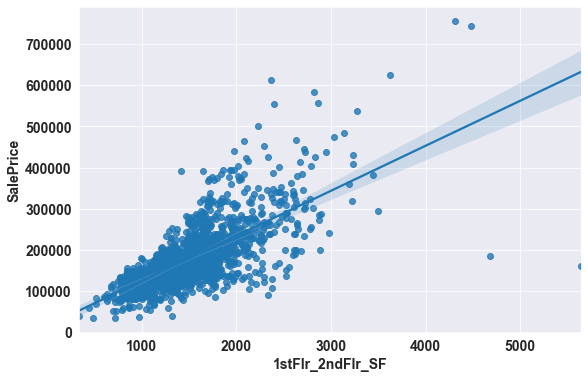

In [37]:
df_train['1stFlr_2ndFlr_SF'] = df_train['1stFlrSF'] + df_train['2ndFlrSF']


f, ax = plt.subplots(figsize=(9, 6))
# seaborn's regression plot
sns.regplot(x=(df_train['1stFlr_2ndFlr_SF']), y=df_train['SalePrice'], data=df_train, order=1)
plt.ylabel('SalePrice',fontsize = 14,fontweight='bold')
plt.xlabel('1stFlr_2ndFlr_SF',fontsize = 14,fontweight='bold')
    # changing the fontsize of y & x ticks
plt.yticks(fontsize=14,fontweight='bold'), plt.xticks(fontsize=14,fontweight='bold')
plt.show()

We can see that there is a significant relationship between the new variable and our target.

Another possibility is OverallGrade.

In [38]:
# overall quality of a house
df_train["OverallGrade"] = df_train["OverallQual"] * df_train["OverallCond"]

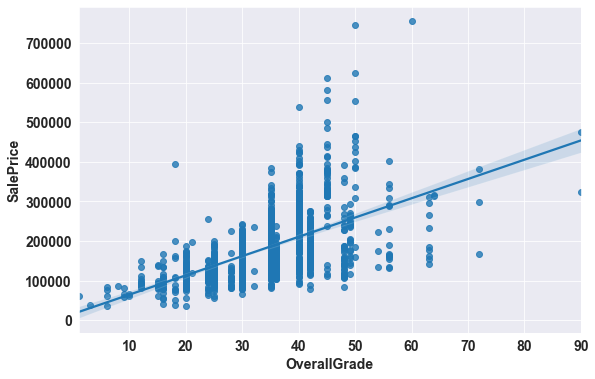

In [39]:
f, ax = plt.subplots(figsize=(9, 6))
# seaborn's regression plot
sns.regplot(x=(df_train['OverallGrade']), y=df_train['SalePrice'], data=df_train, order=1)
plt.ylabel('SalePrice',fontsize = 14,fontweight='bold')
plt.xlabel('OverallGrade',fontsize = 14,fontweight='bold')
    # changing the fontsize of y & x ticks
plt.yticks(fontsize=14,fontweight='bold'), plt.xticks(fontsize=14,fontweight='bold')
plt.show()


Do you have any more ideas for new features? Try to come up with some extra.

Tips: The total square footage of everything, the overall quality of exterior, the total number of bathrooms, the square footage of the porch.

We can also use the automatic approach using, for example, the polynomial expansion.

### Simplification of the Existing Features

We are going to work with ordinal features. We have mapped them to numbers in the previous tutorial. Let's check the distribution per category of GarageQual.


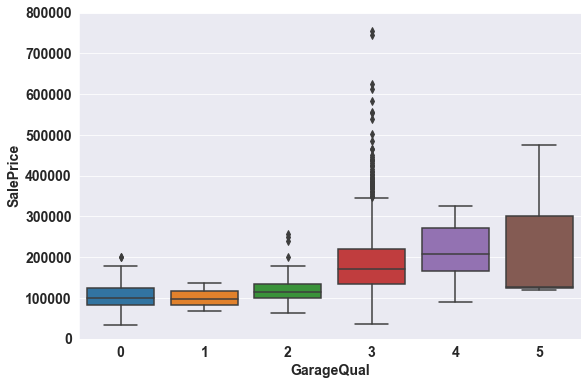

In [40]:

var = 'GarageQual'
f, ax = plt.subplots(figsize=(9, 6))
data = df_train[['SalePrice',var]]
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.ylabel('SalePrice',fontsize = 14,fontweight='bold')
plt.xlabel('GarageQual',fontsize = 14,fontweight='bold')
    # changing the fontsize of y & x ticks
plt.yticks(fontsize=14,fontweight='bold'), plt.xticks(fontsize=14,fontweight='bold')
plt.show()

We can see that there are categories for which the SalePrice is similar. If we move from the category 0 to 1 or 2, there is no change in SalePrice. Therefore, we can merge these categories into one:

In [41]:
df_train["SimplGarageQual"] = df_train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })

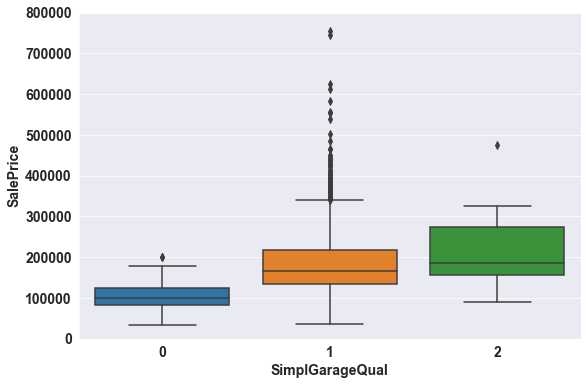

In [42]:
# Now, let's check again the box plots per category:

var = 'SimplGarageQual'
f, ax = plt.subplots(figsize=(9, 6))
data = df_train[['SalePrice',var]]
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.ylabel('SalePrice',fontsize = 14,fontweight='bold')
plt.xlabel('SimplGarageQual',fontsize = 14,fontweight='bold')
    # changing the fontsize of y & x ticks
plt.yticks(fontsize=14,fontweight='bold'), plt.xticks(fontsize=14,fontweight='bold')
plt.show()


We can see that the simplified feature has a "nicer" relationship. If we go from 1 to 2 or 3 the average SalePrice increases.


Find other ordinal variables from the previous tutorial, which can be simplified.

In the end, we will create a new data-frame with numeric features only (including those we have created during transformations).

Create a data-frame df_numeric, where you will put all numeric features from dftrain (including the new ones but excluding the dummy variables from `dfdummy`).

In [43]:
final_num_feats = df_train.dtypes[df_train.dtypes != 'object'].index.tolist()
df_numeric = df_train[final_num_feats]

 **Filter Feature Selection**

We are going to implement elements for filter feature selectors based on the following criteria:
- Small variance
- One of each pair of features, which are correlated together more than x
- Before doing any transformations we will extract our target variable to keep it as it is. Even though we can do some transformations to it, it is a good practice to do it separately:



In [44]:
y = df_numeric.SalePrice
df_numeric.drop("SalePrice",axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Part 1: Removing Features With Small Variance
First of all, we will remove the columns with very little variance. Small variance equals small predictive power because all houses have very similar values.

For most of our variable selection, we can use methods from sklearn:

In [45]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(0.1)
df_transformed = vt.fit_transform(df_numeric)

In [46]:
# columns we have selected
# get_support() is method of VarianceThreshold and stores boolean of each variable in the numpy array.
selected_columns = df_numeric.columns[vt.get_support()]
# transforming an array back to a data-frame preserves column labels
df_transformed = pd.DataFrame(df_transformed, columns = selected_columns)

Check the number of variables in the table and find out how many features we have deleted.

As mentioned last week, fit_transform() in sklearn transforms an object from DataFrame to numpy.array and we are losing column names, so we need to do some tricks to get them back!

We don't need column names for modeling but it helps with the interpretation of modeling results

Part 2: Removing Correlated Features
    
The goal of this part is to remove one feature from each highly correlated pair.

We are going to do this in 3 steps:
- Calculate a correlation matrix
- Get pairs of highly correlated features
- Remove correlated columns

In [47]:
# step 1
df_corr = df_transformed.corr().abs()

# step 2
indices = np.where(df_corr > 0.8) 
indices = [(df_corr.index[x], df_corr.columns[y]) 
for x, y in zip(*indices)
    if x != y and x < y]

# step 3
for idx in indices: #each pair
    try:
        df_transformed.drop(idx[1], axis = 1, inplace=True)
    except KeyError:
        pass

The code above will drop one column from each pair that is correlated at least 0.8. If this happens twice, use try-except block to allow the code to continue even when KeyError occurs.

We can check the correlated columns by printing the indices:

In [48]:
print(indices)

[('TotalBsmtSF', '1stFlrSF'), ('GrLivArea', 'TotRmsAbvGrd'), ('GrLivArea', '1stFlr_2ndFlr_SF'), ('TotRmsAbvGrd', '1stFlr_2ndFlr_SF'), ('GarageCars', 'GarageArea'), ('GarageQual', 'GarageCond')]


In [49]:
df_transformed.head()

,Id,MSSubClass,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage_missing_ind,OverallGrade
0,1.0,60.0,65.0,8450.0,4.0,7.0,5.0,2003.0,2003.0,196.0,...,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,0.0,35.0
1,2.0,20.0,80.0,9600.0,4.0,6.0,8.0,1976.0,1976.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,0.0,48.0
2,3.0,60.0,68.0,11250.0,3.0,7.0,5.0,2001.0,2002.0,162.0,...,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,0.0,35.0
3,4.0,70.0,60.0,9550.0,3.0,7.0,5.0,1915.0,1970.0,0.0,...,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,0.0,35.0
4,5.0,60.0,84.0,14260.0,3.0,8.0,5.0,2000.0,2000.0,350.0,...,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,0.0,40.0


Part 3: Forward Regression

We have removed the features with no information and correlated features so far. The last thing we will do before modeling is to select the k-best features in terms of the relationship with the target variable. We will use the forward wrapper method for that:

In [50]:
from sklearn.feature_selection import f_regression, SelectKBest
skb = SelectKBest(f_regression, k=10)
X = skb.fit_transform(df_transformed, y)

We need to import the SelectKBest method. Plus, we have to decide what algorithm we are going to use for the actual selection. Since we want to do a forward regression, we also imported f_regression. We could use some other technique if, for example, the target variable was categorical.


We have assigned our target variable SalePrice into y in the beginning of this tutorial.

The type of X was again changed to array.

Convert X back to a data-frame and assign back the correct column names.

HINT: Use the method get_support() from the SelectKBest instance to find the features that were selected.

Try to do it before looking at the solution below.

In [51]:
# this will give us the position of top 10 columns
skb.get_support()
# column names
df_transformed.columns[skb.get_support()]
X = pd.DataFrame(X,columns=df_transformed.columns[skb.get_support()])

Now, X consists of 10 features which should be pretty good predictors of our target variable, SalePrice.



In [53]:
X.head()

,OverallQual,YearBuilt,ExterQual,BsmtQual,TotalBsmtSF,GrLivArea,FullBath,KitchenQual,GarageCars,OverallGrade
0,7.0,2003.0,4.0,4.0,856.0,1710.0,2.0,4.0,2.0,35.0
1,6.0,1976.0,3.0,4.0,1262.0,1262.0,2.0,3.0,2.0,48.0
2,7.0,2001.0,4.0,4.0,920.0,1786.0,2.0,4.0,2.0,35.0
3,7.0,1915.0,3.0,3.0,756.0,1717.0,1.0,4.0,3.0,35.0
4,8.0,2000.0,4.0,4.0,1145.0,2198.0,2.0,4.0,3.0,40.0


Predicting House Prices with Linear Regression
We can continue in the same notebook as in the previous activity Variable Selection.

We finished with DataFrame X with 10 variables. We will fit linear regression to this and explore if all these attributes are significant. There are two main interpretations of linear regression in Python:

statsmodels
sklearn

statsmodels
First of all, we will import statsmodel into our notebook:

In [157]:
import statsmodels.api as sm


We have to add an intercept to our predictive dataset to also estimate the intercept. If we don't do that the intercept will be considered 0.



In [158]:
X = sm.add_constant(X) # adding a constant


Now, we can create a Python object that will represent linear regression:



In [159]:
lin_reg = sm.OLS(y,X)


If we use the type() function, we will see that the object lin_reg is a linear model with the ordinary least square method.

As the next step, we will fit this using our training data and export the summary of the model:

In [160]:
model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     732.0
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        01:42:17   Log-Likelihood:                -17206.
No. Observations:                1458   AIC:                         3.443e+04
Df Residuals:                    1447   BIC:                         3.449e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.992e+05   8.93e+04    -10.069   

sklearn
We need to import our model first:

In [161]:
from sklearn.linear_model import LinearRegression

In [162]:
#Then we initialize the object and fit the model on our data:

regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

This gives us an overview of the parameters we can set up for linear regression in sklearn. The most important one is fit_intercept. In sklearn, we don't have to add a constant to a dataset. We have to set this parameter to the value True if we want to compute an intercept as well.

We can check the beta coefficient now:

In [163]:
print(regressor.coef_)


[     0.           5507.54189138    392.2863556   14466.78601472
    920.78618122     42.13854481     66.85496149 -11218.59562134
  11469.89475761   9314.43585305   1078.19597724]


This will show us a NumPy array with beta coefficients. They have the same order as our columns in X. the first one is 0 because we have added a constant column before statsmodel modeling. This column doesn't have any meaning is sklearn so we could have dropped that before.

We can see that the results look much nicer in the statsmodel package. Another huge disadvantage of sklearn is that we don't have access to p-values, so we cannot check the importance of different variables for prediction.

If we want to know the R-squared, we can get it with:

In [164]:
regressor.score(X,y)

0.8349492071391902

In [165]:
# Run a linear regression model
lr = LinearRegression()           # Select the estimator
lr.fit(X, y)               # Fit the model

# Print the coefficients
print ("intercept : ",lr.intercept_)
print ("coefficient : ",lr.coef_)

intercept :  -899203.1119366712
coefficient :  [     0.           5507.54189138    392.2863556   14466.78601472
    920.78618122     42.13854481     66.85496149 -11218.59562134
  11469.89475761   9314.43585305   1078.19597724]
